In [1]:
# Tabular data structure library 

import pandas as pd 

# Linear algebra library of python 

import numpy as np 

# For CUDA compatibility

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Uncomment this line for use of CPU only otherwise GPU scaling is enabled

# For visualisation and plotting

import matplotlib.pyplot as plt

# Import train/test split

from sklearn.model_selection import train_test_split

# Encoding

from sklearn.preprocessing import LabelEncoder

# Keras and Tensorflow for deep learning framework

from keras.utils import np_utils
from tensorflow import keras

from tensorflow.keras.layers import Conv1D, Dense, Input, Activation, Multiply, Add, ReLU, Softmax, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeNormal

# Custom confusion matrix package

import confusion_matrix_pretty_print as cmpp

# Evaluation packages

from sklearn.metrics import confusion_matrix, classification_report

# File import library

import pickle

In [3]:
# Load data and labels in

X = np.load('wav_files_np.npy')
y = np.load('labels_np.npy')

In [4]:
# Encode the labels 

encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)

dummy_y = np_utils.to_categorical(encoded_Y)

# Split the train and test data

X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.33, random_state=42,stratify=dummy_y)

## Train data size reduction

In [5]:
# To again keep the same distribution we will use stratified splitting
# The second split only touches the training data so that the original test_data will be the same for all experiments
# We remove 60% of the original training data

X_train_reduced, Unused_rows, y_train_reduced, Unused_labels = train_test_split(X_train, y_train, test_size=0.6, random_state=42,stratify=y_train)

In [6]:
print(len(X_train)) # Before
print(len(X_train_reduced)) # After

70905
28362


## WaveNet model

In [7]:
# Define a wavenet block that can be used to stack them

def wavenet_block(input_layer, dilation_rate):
    dilated_conv = Conv1D(32, kernel_size=2, dilation_rate=dilation_rate, padding='same')(input_layer) # Dilated conv layer
    
    tanh_act = Activation('tanh')(dilated_conv) # Hyperbolic tangent non linearity
    sigmoid_act = Activation('sigmoid')(dilated_conv) # Sigmoid non linearity
    
    multiplication_output = Multiply()([tanh_act, sigmoid_act]) # Multiply both non linearities
    one_conv = Conv1D(32, kernel_size=1, padding='same')(multiplication_output) 
    
    residual_output = Add()([one_conv, input_layer]) # Add the input with the last layer (skip connection)
    
    return one_conv, residual_output # Return the output for the skip connection and for the next block

# Causal conv layer
input_layer = Input(shape=(99,13))
causal_conv = Conv1D(32, kernel_size=3, padding="causal")(input_layer)

x = causal_conv

dilation_rates = [1, 2, 4, 8] # Dilation rates to alter with

one_conv_outputs = [] # Skip connections to the end

for i in range(24): # Residual block count
    one_conv_output, x = wavenet_block(x, dilation_rates[i % 4])
    one_conv_outputs.append(one_conv_output)


skip_assembly = Add()(one_conv_outputs) # Add all skip connected outputs

x = ReLU()(skip_assembly) # Non linearity
x = Conv1D(32, kernel_size=1)(x) # 1d conv layer
x = ReLU()(x) 
x = Conv1D(35, kernel_size=1)(x)
x = GlobalAveragePooling1D()(x) # In order to make it work with SoftMax

output = Softmax()(x) # Final output - probability for all class labels (keywords)

# Define and compile model

model = Model(inputs=[input_layer], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print a summary to verify layout

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 99, 13)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 99, 32)       1280        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 99, 32)       2080        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 32)       0           conv1d_1[0][0]                   
______________________________________________________________________________________________

## Train the network

In [9]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=30,batch_size=128) # History in order to plot

Epoch 1/30
222/222 [==============================] - 127s 547ms/step - loss: 3.2511 - accuracy: 0.1280 - val_loss: 2.3535 - val_accuracy: 0.3473
Epoch 2/30
222/222 [==============================] - 125s 564ms/step - loss: 2.2273 - accuracy: 0.3846 - val_loss: 1.9193 - val_accuracy: 0.4745
Epoch 3/30
222/222 [==============================] - 124s 561ms/step - loss: 1.8183 - accuracy: 0.5021 - val_loss: 1.5790 - val_accuracy: 0.5786
Epoch 4/30
222/222 [==============================] - 122s 552ms/step - loss: 1.4888 - accuracy: 0.6033 - val_loss: 1.2650 - val_accuracy: 0.6672
Epoch 5/30
222/222 [==============================] - 126s 567ms/step - loss: 1.2170 - accuracy: 0.6825 - val_loss: 1.1037 - val_accuracy: 0.7050
Epoch 6/30
222/222 [==============================] - 123s 553ms/step - loss: 1.0443 - accuracy: 0.7241 - val_loss: 0.9551 - val_accuracy: 0.7414
Epoch 7/30
222/222 [==============================] - 121s 545ms/step - loss: 0.9170 - accuracy: 0.7533 - val_loss: 0.8984 -

In [10]:
# Save model for later evaluation / convenience

model.save('saved_models_data_reduction/WaveNet_40pct.hdf5')

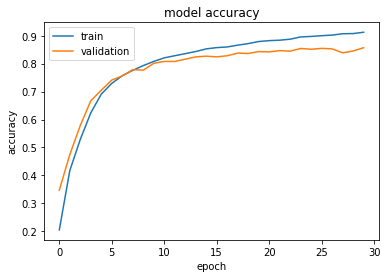

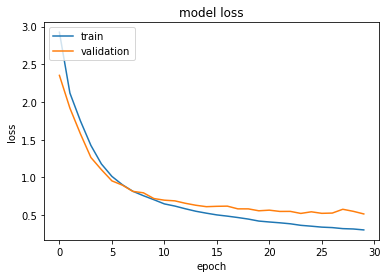

In [11]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
# Save history data for plotting in external software

np.save('WaveNet_40pct.npy',history.history)

In [13]:
predictions = np.argmax(model.predict(X_test), axis=-1)
np.unique(predictions) # Unique values for its respective class

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34], dtype=int64)

In [14]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} - & - Test accuracy: {score[1]}')

Test loss: 0.5165078043937683 - & - Test accuracy: 0.8570610284805298


C:\Users\Lieuwe\Desktop\School\Radboud\Master\Semester 2\Automatic Speech Recognition\asr-project\confusion_matrix_pretty_print.py:165: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\Lieuwe\Desktop\School\Radboud\Master\Semester 2\Automatic Speech Recognition\asr-project\confusion_matrix_pretty_print.py:166: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
C:\Users\Lieuwe\Desktop\School\Radboud\Master\Semester 2\Automatic Speech Recognition\asr-project\confusion_matrix_pretty_print.py:168: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\Lieuwe\Desktop\School\Radboud\Master\Semester 2\Automatic Speech

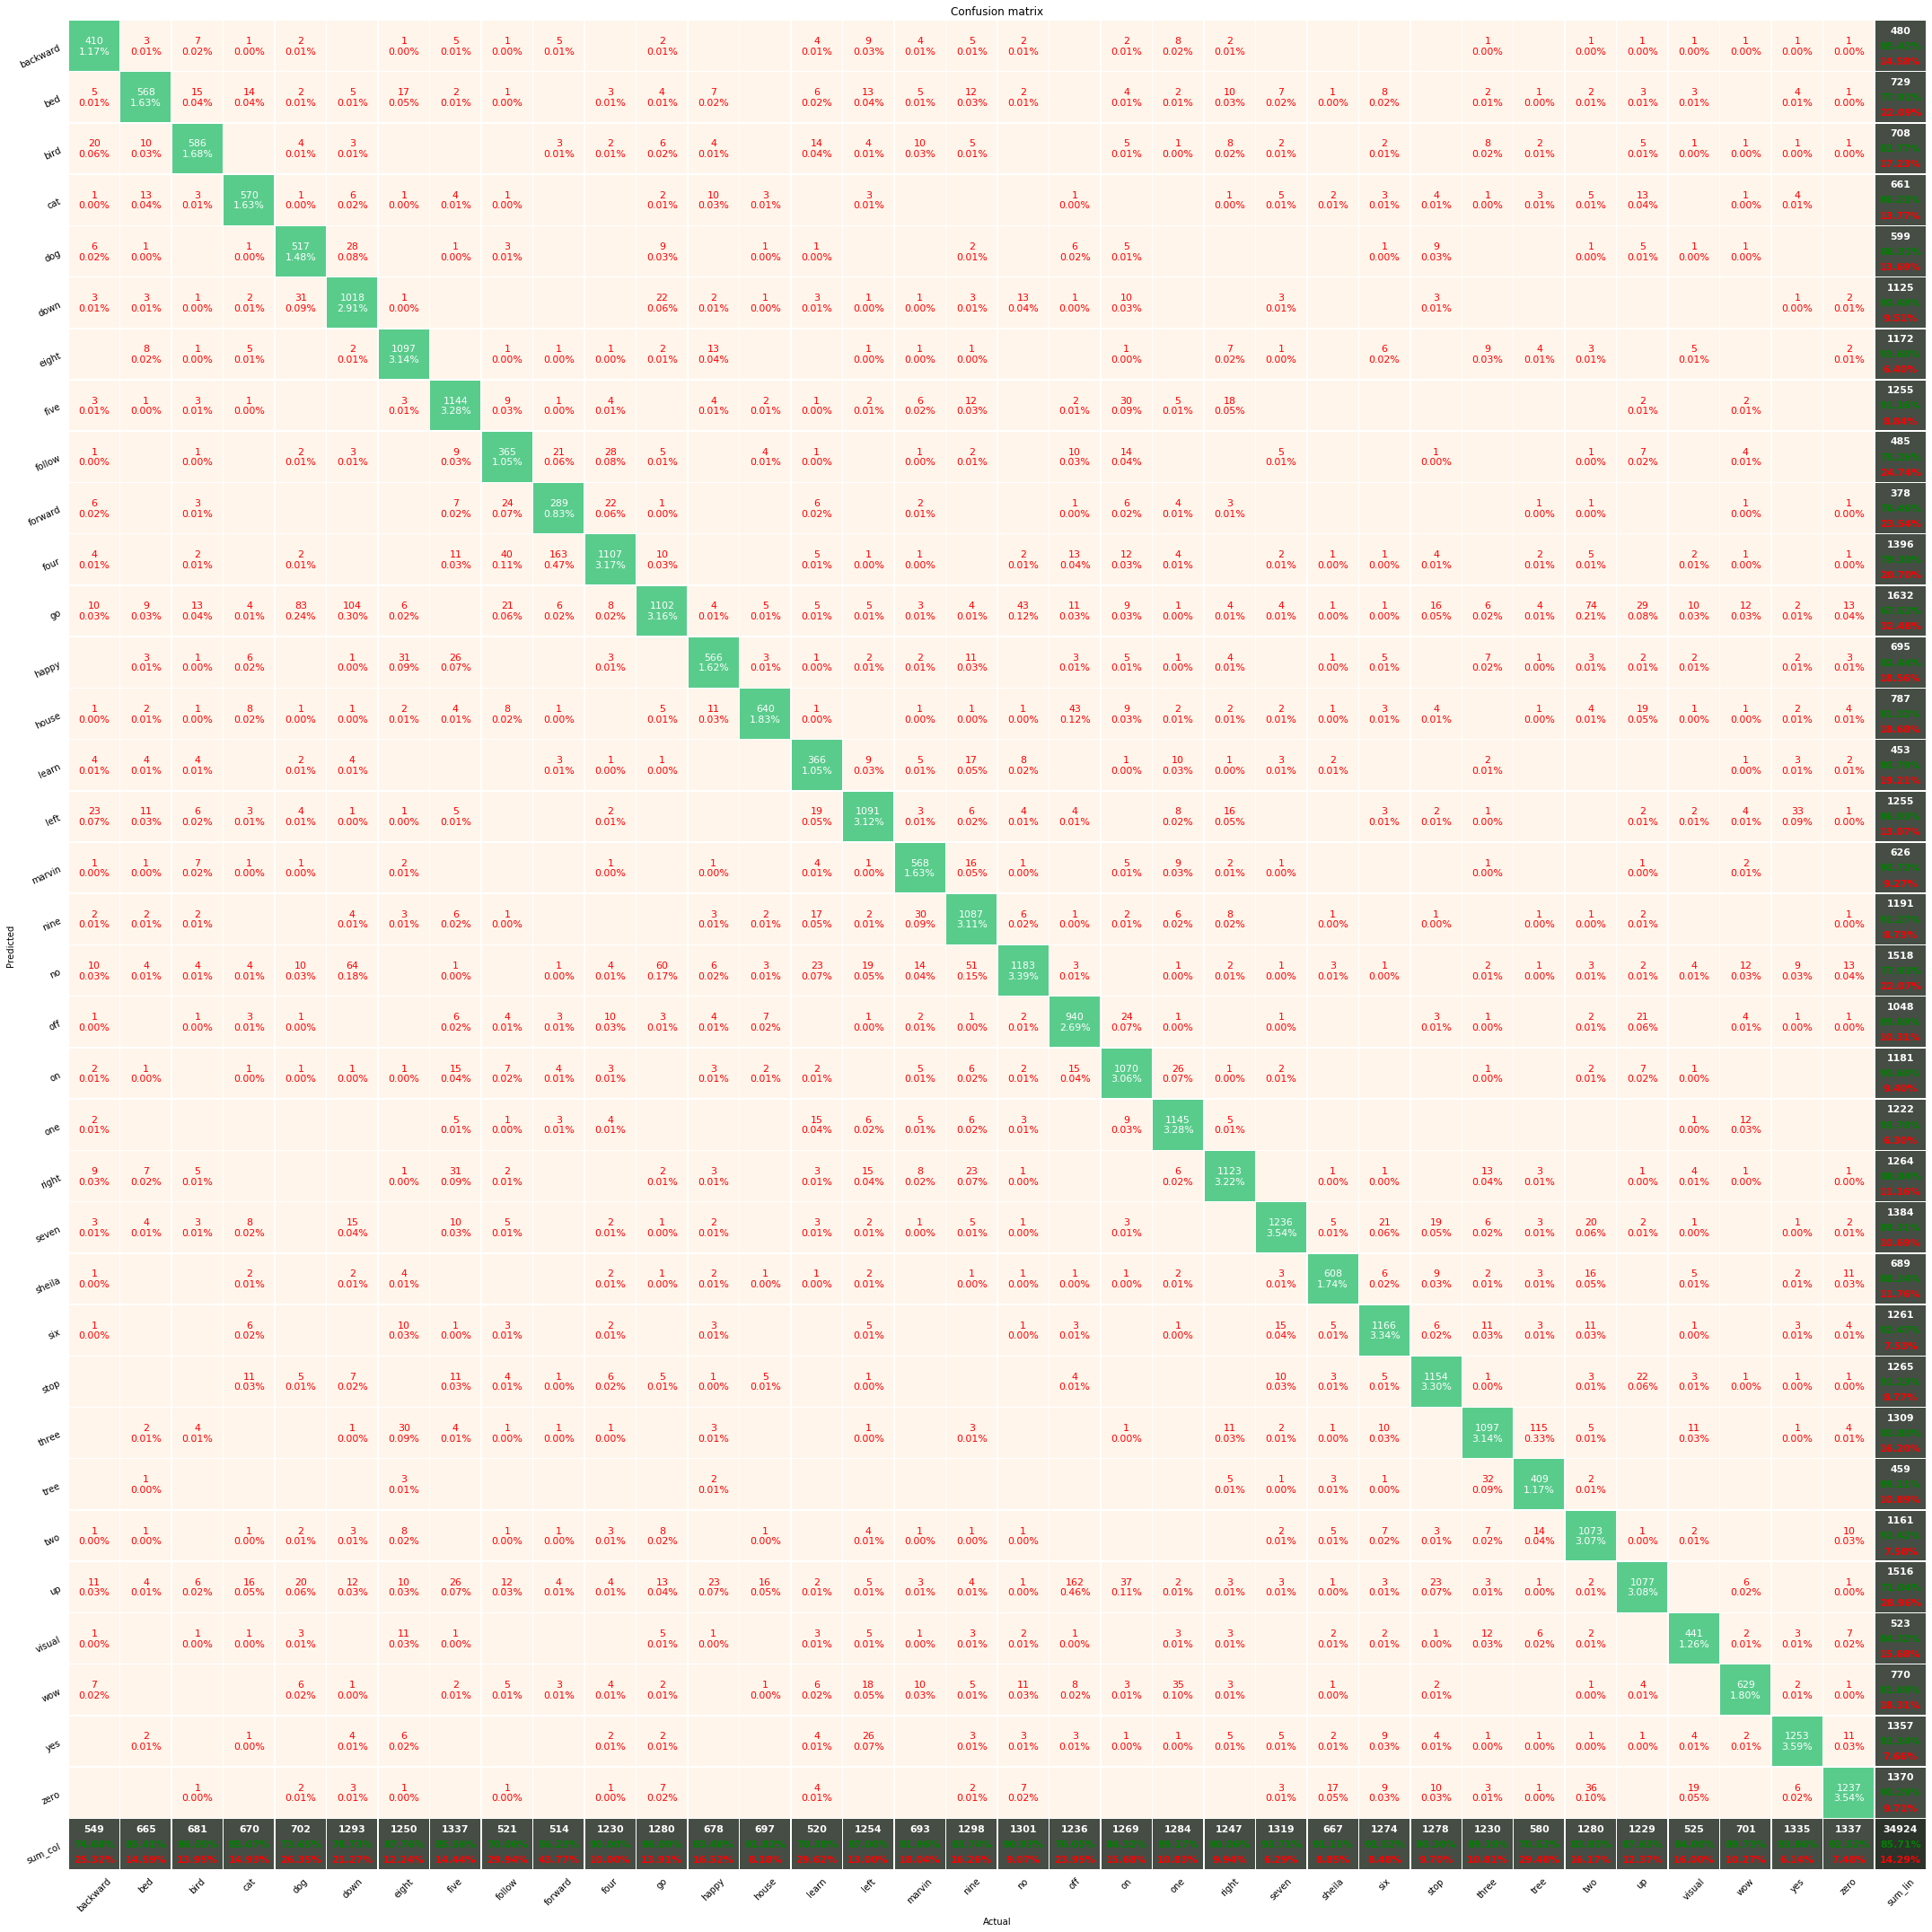

In [15]:
# Original labels of the dataset
cm_plot_labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

# Create a confusion matrix 
Original_y = np.argmax(y_test,axis=1)
cm = confusion_matrix(y_true=Original_y, y_pred=predictions)

# Transform the confusion matrix to a dataframe with the actual labels as rows/ columns
df = pd.DataFrame(cm, index=cm_plot_labels)
df.columns = cm_plot_labels

# Call a pretty plot confusion matrix function
cmpp.pretty_plot_confusion_matrix(df,figsize=[30,30])

# Many thanks to the author for making this script publicly available on GitHub!
# https://github.com/wcipriano/pretty-print-confusion-matrix

In [16]:
# Print classification report

print(classification_report(Original_y, predictions,target_names=cm_plot_labels))

              precision    recall  f1-score   support

    backward       0.85      0.75      0.80       549
         bed       0.78      0.85      0.81       665
        bird       0.83      0.86      0.84       681
         cat       0.86      0.85      0.86       670
         dog       0.86      0.74      0.79       702
        down       0.90      0.79      0.84      1293
       eight       0.94      0.88      0.91      1250
        five       0.91      0.86      0.88      1337
      follow       0.75      0.70      0.73       521
     forward       0.76      0.56      0.65       514
        four       0.79      0.90      0.84      1230
          go       0.68      0.86      0.76      1280
       happy       0.81      0.83      0.82       678
       house       0.81      0.92      0.86       697
       learn       0.81      0.70      0.75       520
        left       0.87      0.87      0.87      1254
      marvin       0.91      0.82      0.86       693
        nine       0.91    